# 0. Install and Import Dependencies

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2024-03-05 11:04:47.069134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 11:04:47.069187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 11:04:47.071128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 11:04:47.080817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 11:04:47.960003: W tensorflow/compiler/tf2

In [2]:
tf.config.list_physical_devices('GPU') 

2024-03-05 11:04:51.048279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2024-03-05 11:04:51.117309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 11:04:51.117592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [4]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,85:260,:])#For both
        # frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


2024-03-05 11:05:02.809257: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 11:05:02.809588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 11:05:02.809787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [8]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [9]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    # file_name = path.split('/')[-1].split('.')[0]
    #File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/home','mahimrawal','Lip_Reading','combine','s1',f'{file_name}.mpg') #/home/mahimrawal/Lip_Reading/data
    alignment_path = os.path.join('/home','mahimrawal','Lip_Reading','combine','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [10]:
# test_path = 'content/data/alignments/s1/bbal6n.align'
test_path = '/home/mahimrawal/Lip_Reading/combine/alignments/s1/bbal6n.align'

In [11]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [12]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))


2024-03-05 11:05:06.273968: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


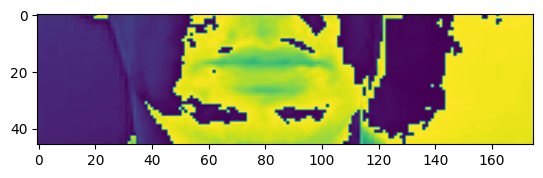

In [13]:
plt.imshow(frames[70])

In [14]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [15]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [16]:
data = tf.data.Dataset.list_files('/home/mahimrawal/Lip_Reading/combine/s1/*.mpg')
data = data.shuffle(900, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(900)
test = data.skip(900)

In [17]:
len(train)

900

In [18]:
len(test)

100

In [19]:
frames, alignments = data.as_numpy_iterator().next()

In [20]:
len(frames)

2

In [21]:
sample = data.as_numpy_iterator()

In [22]:
val = sample.next(); val[0]

array([[[[[ 1.3384818 ],
          [ 1.3384818 ],
          [ 1.3384818 ],
          ...,
          [ 9.856092  ],
          [ 9.896653  ],
          [ 9.693852  ]],

         [[ 1.3384818 ],
          [ 1.3384818 ],
          [ 1.3384818 ],
          ...,
          [ 9.977773  ],
          [ 9.977773  ],
          [ 9.774973  ]],

         [[ 1.2979217 ],
          [ 1.2979217 ],
          [ 1.2979217 ],
          ...,
          [ 0.04056005],
          [10.140013  ],
          [ 9.856092  ]],

         ...,

         [[ 1.0545614 ],
          [ 1.0545614 ],
          [ 1.0545614 ],
          ...,
          [ 9.247692  ],
          [ 9.693852  ],
          [10.058893  ]],

         [[ 1.0545614 ],
          [ 1.0545614 ],
          [ 1.0545614 ],
          ...,
          [ 9.126012  ],
          [ 9.491053  ],
          [ 9.815533  ]],

         [[ 1.0545614 ],
          [ 1.0545614 ],
          [ 1.0545614 ],
          ...,
          [ 9.247692  ],
          [ 9.531612  ],
          

In [23]:
#imageio.mimsave('/content/animation1.mp4', val[0][0], fps=10)

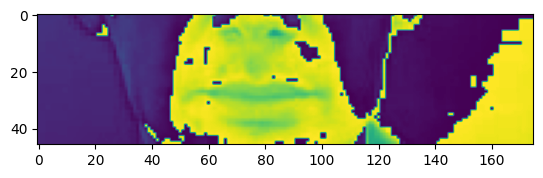

In [24]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][1][74])

In [25]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in i one please'>

# 3. Design the Deep Neural Network

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler



In [27]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 175, 1)

In [28]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,175,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 175, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 175, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 87, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 87, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 87, 256)   0         
                                                        

In [30]:
yhat = model.predict(val[0])

2024-03-05 11:05:19.387526: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-05 11:05:19.483648: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


In [31]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'444444444444444444444444444444444444444444444444444444444444444444444444hhh'>

In [32]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'444444444444444444444444444444444444444444444444444444444444444444444444hhh'>

In [33]:
model.input_shape

(None, 75, 46, 175, 1)

In [34]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [35]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [36]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss/100

In [37]:
# # class ProduceExample(tf.keras.callbacks.Callback):
# #     def __init__(self, dataset) -> None:
# #         self.dataset = dataset.as_numpy_iterator()

# #     def on_epoch_end(self, epoch, logs=None) -> None:
# #         data = self.dataset.next()
# #         yhat = self.model.predict(data[0])
# #         decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
# #         for x in range(len(yhat)):
# #             print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
# #             print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
# #             print('~'*100)


# class ProduceExample(tf.keras.callbacks.Callback):
#     def __init__(self, dataset):
#         super().__init__()
#         self.dataset = dataset.as_numpy_iterator()
#         self.total_letters = 0
#         self.correct_letters = 0
#         self.letter_accuracies = []  # Store letter accuracy values for each epoch

#     def on_epoch_begin(self, epoch, logs=None):
#         self.total_letters = 0
#         self.correct_letters = 0

#     def on_epoch_end(self, epoch, logs=None):
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

#         for x in range(len(yhat)):
#             original= tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
#             prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
            
#             original_words = original.split()
#             prediction_words = prediction.split()

#             for orig_word, pred_word in zip(original_words, prediction_words):
#                 for orig_char, pred_char in zip(orig_word, pred_word):
#                     self.total_letters += 1
#                     if orig_char == pred_char:
#                         self.correct_letters += 1

#             print('Original:', original)
#             print('Prediction:', prediction)
#             print('~' * 100)

#         # Calculate and print letter-level accuracy
#         accuracy = self.correct_letters / self.total_letters if self.total_letters > 0 else 0.0
#         self.letter_accuracies.append(accuracy)  # Store accuracy for the epoch
#         print(f'Letter-level Accuracy: {accuracy:.4f}')
    

In [38]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):  
            originals= tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
            predictions = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
            
            # Tokenize the input strings into lists of words
            prediction = predictions.split()
            original = originals.split()

            # Initialize dynamic programming matrix
            dp_matrix = [[0] * (len(original) + 1) for _ in range(len(prediction) + 1)]

            # Fill the matrix
            for i in range(len(prediction) + 1):
                for j in range(len(original) + 1):
                    if i == 0:
                        dp_matrix[i][j] = j
                    elif j == 0:
                        dp_matrix[i][j] = i
                    else:
                        substitution_cost = 0 if prediction[i - 1] == original[j - 1] else 1
                        dp_matrix[i][j] = min(
                            dp_matrix[i - 1][j] + 1,  # Deletion
                            dp_matrix[i][j - 1] + 1,  # Insertion
                            dp_matrix[i - 1][j - 1] + substitution_cost  # Substitution
                        )
            # Calculate WER
            wer = dp_matrix[len(prediction)][len(original)] / len(original)
            print(f'Word error rate : {wer}')



            pred_chars = list(predictions)
            truth_chars = list(originals)
            # Initialize dynamic programming matrix
            dp_matrix = [[0] * (len(truth_chars) + 1) for _ in range(len(pred_chars) + 1)]

            # Fill the matrix
            for i in range(len(pred_chars) + 1):
                for j in range(len(truth_chars) + 1):
                    if i == 0:
                        dp_matrix[i][j] = j
                    elif j == 0:
                        dp_matrix[i][j] = i
                    else:
                        substitution_cost = 0 if pred_chars[i - 1] == truth_chars[j - 1] else 1
                        dp_matrix[i][j] = min(
                            dp_matrix[i - 1][j] + 1,  # Deletion
                            dp_matrix[i][j - 1] + 1,  # Insertion
                            dp_matrix[i - 1][j - 1] + substitution_cost  # Substitution
                        )

            # Calculate CER
            cer = dp_matrix[len(pred_chars)][len(truth_chars)] / len(truth_chars)
            print(f'Character error rate : {cer}')

            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [39]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss=CTCLoss)

In [40]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [41]:
schedule_callback = LearningRateScheduler(scheduler)

In [42]:
example_callback = ProduceExample(test)

In [43]:
model.load_weights('/home/mahimrawal/models/checkpoint')

In [44]:
history = model.fit(train, validation_data=test, epochs=32, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/32


2024-03-05 11:05:46.918406: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff7c889edf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 11:05:46.918443: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-03-05 11:05:46.932325: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709636747.040848  944061 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 11/900 [..............................] - ETA: 7:16 - loss: 0.1641

KeyboardInterrupt: 

In [ ]:
history_dict = history.history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


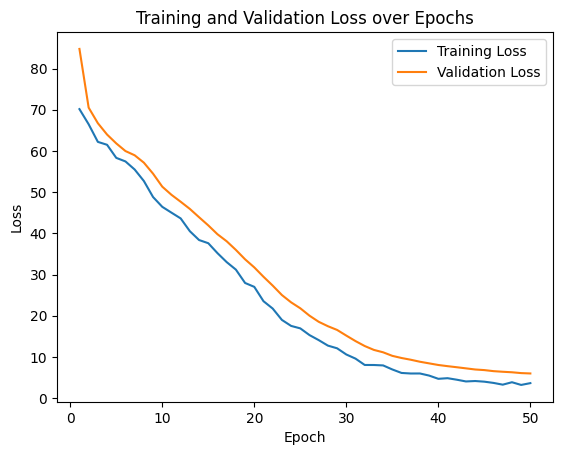

In [ ]:
import matplotlib.pyplot as plt

# Read the contents of the nohup.out file
with open('/home/mahimrawal/loss_values.txt', 'r') as file:
    lines = file.readlines()

# Extract loss and val_loss values for each epoch
epochs = []
loss_values = []
val_loss_values = []

for line in lines:
    if 'Epoch' in line:
        epoch_info = line.split()
        epoch = int(epoch_info[1].split('/')[0])
        epochs.append(epoch)
        
        if 'loss:' in epoch_info:
            loss_index = epoch_info.index('loss:')
            loss = float(epoch_info[loss_index + 1])
        else:
            loss = None
        # Check if 'val_loss:' is present in the line
        if 'val_loss:' in epoch_info:
            val_loss_index = epoch_info.index('val_loss:')
            val_loss = float(epoch_info[val_loss_index + 1])
        else:
            val_loss = None

        loss_values.append(loss)
        val_loss_values.append(val_loss)

# Plotting
plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


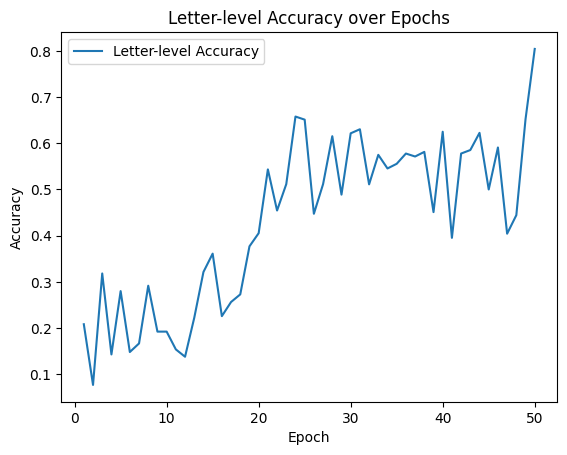

In [ ]:
import matplotlib.pyplot as plt

# Read the contents of the nohup.out file
with open('/home/mahimrawal/loss_values.txt', 'r') as file:
    lines = file.readlines()

# Extract letter-level accuracy values for each epoch
epochs = []
accuracy_values = []

for line in lines:
    if 'Epoch' in line:
        epoch_info = line.split()
        epoch = int(epoch_info[1].split('/')[0])
        epochs.append(epoch)

        # Extract letter-level accuracy
        accuracy_index = epoch_info.index('Accuracy:')
        accuracy = float(epoch_info[accuracy_index + 1])
        
        accuracy_values.append(accuracy)

# Plotting
plt.plot(epochs, accuracy_values, label='Letter-level Accuracy')
plt.title('Letter-level Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 5. Make a Prediction

In [ ]:
model.load_weights('/home/mahimrawal/models checkpoint47/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('/home/mahimrawal/Lip_Reading/data/s1/bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]